In [1]:
# data library
from sklearn.datasets import fetch_openml

# utilities to more easily process the data
# (yes, tensorflow is overkill)
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

import numpy as np

# pip install --user ipywidgets
# jupyter nbextension install --py widgetsnbextension --user
# jupyter nbextension enable widgetsnbextension --user --py
from tqdm.autonotebook import tqdm

from matplotlib import pyplot as plt
import pickle
import os

# fix caching / parsing extreme-slowness bug in fetch_openml()
# by replacing the whole function with an outer cache
from joblib import Memory
memory = Memory('./tmp')
fetch_openml_cached = memory.cache(fetch_openml)

<ipython-input-1-0b5b6c979daa>:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
x, y = fetch_openml_cached('mnist_784', version = 1, cache = True, return_X_y = True, as_frame = False)

x = (x / 255).astype('float32')
y = to_categorical(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [3]:
def nn_init(lsize):
    # human-readable names for clarity
    input_layer  = lsize[0]
    hidden_1     = lsize[1]
    hidden_2     = lsize[2]
    output_layer = lsize[3]
    
    # narrowing down the standard deviation by layer size, with np.sqrt()
    # large layers have tighter initial values
    nnet = {
        'w0': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
        'w1': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
        'w2': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
    }
    return nnet

layer_sizes = [x_train[0].shape[0], 128, 64, y_train[0].shape[0]]
model = nn_init(layer_sizes)

In [4]:
def forward_pass(x):
    # the model is a global var, used here read-only
    
    # NN state: internal sums, neuron outputs
    nn_state = {}
    
    # "output zero" is the output from receptors = input to first layer in the NN
    # these are activations for the input layer
    nn_state['o0'] = x
    
    # from input layer to hidden layer 1
    # weighted sum of all activations, then sigmoid
    nn_state['z1'] = np.dot(model['w0'], nn_state['o0'])
    nn_state['o1'] = sigmoid(nn_state['z1'])
    
    # from hidden 1 to hidden 2
    nn_state['z2'] = np.dot(model['w1'], nn_state['o1'])
    nn_state['o2'] = sigmoid(nn_state['z2'])
    
    # from hidden 2 to output
    nn_state['z3'] = np.dot(model['w2'], nn_state['o2'])
    nn_state['o3'] = softmax(nn_state['z3'])
    
    return nn_state


def backward_pass(x, y):
    # do the forward pass, register the state of the network
    nn_state = forward_pass(x)
    
    # small deltas: derivatives of the error w.r.t. z
    nn_state['d3'] = nn_state['o3'] - y
    nn_state['d2'] = np.dot(nn_state['d3'], model['w2']) * softmax(nn_state['z2'], derivative = True)
    nn_state['d1'] = np.dot(nn_state['d2'], model['w1']) * sigmoid(nn_state['z1'], derivative = True)
    
    # large deltas: adjustments to weights
    nn_state['D2'] = np.outer(nn_state['d3'], nn_state['o2'])
    nn_state['D1'] = np.outer(nn_state['d2'], nn_state['o1'])
    nn_state['D0'] = np.outer(nn_state['d1'], nn_state['o0'])
    
    return nn_state


def part_cost(o, y):
    c = np.dot(y, np.log(o)) + np.dot((1 - y), np.log(1 - o))
    return -c


def sigmoid(x, derivative = False):
    if derivative:
        return np.exp(-x) / ((np.exp(-x) + 1) ** 2)
    else:
        return 1 / (1 + np.exp(-x))


def softmax(x, derivative = False):
    # for stability, we shift values down so max = 0
    # https://cs231n.github.io/linear-classify/#softmax
    exp_shifted = np.exp(x - x.max())
    if derivative:
        return exp_shifted / np.sum(exp_shifted, axis = 0) * (1 - exp_shifted / np.sum(exp_shifted, axis = 0))
    else:
        return exp_shifted / np.sum(exp_shifted, axis = 0)

In [5]:
epochs = 5
t_rate = 0.001

# train
print('################### training ####################')
for e in range(epochs):
    print('epoch:', e)
    
    samples = x_train.shape[0]
    cost = 0
    hit_count = 0
    for i in tqdm(range(samples)):
        m_state = backward_pass(x_train[i], y_train[i])
        # add partial cost
        cost += part_cost(m_state['o3'], y_train[i])
        
        # stochastic gradient descent
        # update weights
        model['w0'] -= t_rate * m_state['D0']
        model['w1'] -= t_rate * m_state['D1']
        model['w2'] -= t_rate * m_state['D2']
        
        if np.argmax(m_state['o3']) == np.argmax(y_train[i]):
            # successful detection
            hit_count += 1

    # performance evaluation
    cost = cost / samples
    accuracy = hit_count / samples
    print('cost:', cost, 'accuracy:', accuracy)

# save the model
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

################### training ####################
epoch: 0


  0%|          | 0/49000 [00:00<?, ?it/s]

cost: 3.1868798789462143 accuracy: 0.24308163265306124
epoch: 1


  0%|          | 0/49000 [00:00<?, ?it/s]

cost: 3.0205047955156283 accuracy: 0.42848979591836733
epoch: 2


  0%|          | 0/49000 [00:00<?, ?it/s]

cost: 2.8576527750581207 accuracy: 0.5313061224489796
epoch: 3


  0%|          | 0/49000 [00:00<?, ?it/s]

cost: 2.6988496229740426 accuracy: 0.5843877551020408
epoch: 4


  0%|          | 0/49000 [00:00<?, ?it/s]

cost: 2.5663423846965614 accuracy: 0.6173877551020408


In [6]:
# test
print('################### testing ####################')

# load the model
if os.path.isfile('model.pickle'):
    with open('model.pickle', 'rb') as f:
        model = pickle.load(f)

# run the whole test data
samples = x_test.shape[0]
cost = 0
hit_count = 0
for i in tqdm(range(samples)):
    m_state = forward_pass(x_test[i])
    cost += part_cost(m_state['o3'], y_test[i])
    if np.argmax(m_state['o3']) == np.argmax(y_test[i]):
        hit_count += 1

# evaluate performance
cost = cost / samples
accuracy = hit_count / samples
print('cost:', cost, 'accuracy:', accuracy)

################### testing ####################


  0%|          | 0/21000 [00:00<?, ?it/s]

cost: 2.53188801280013 accuracy: 0.6292380952380953


# Data Samples

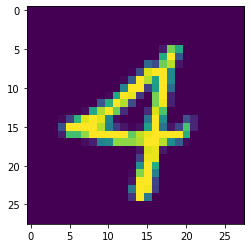

In [7]:
plt.imshow(np.reshape(x_train[2], (28, 28)));

In [8]:
y_train[2].astype(int).tolist()

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

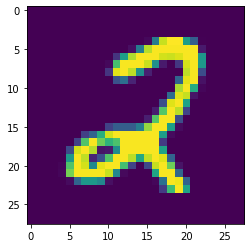

In [9]:
plt.imshow(np.reshape(x_train[6], (28, 28)));

In [10]:
y_train[6].astype(int).tolist()

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

# Sigmoid

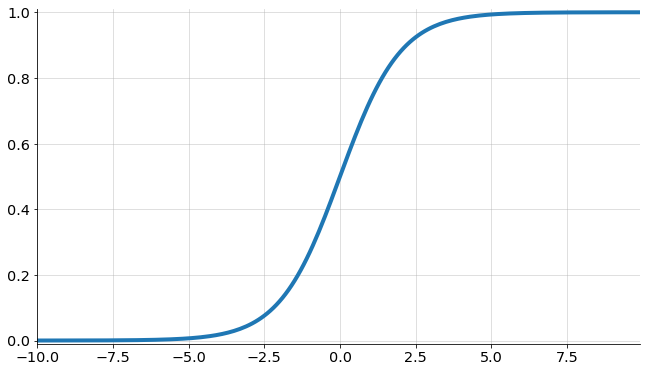

In [11]:
x = np.arange(-10, 10, 0.1)
y = 1 / (1 + np.exp(-x))
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['lines.marker'] = ''
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'
plt.rcParams['figure.subplot.top'] = 0.98
plt.rcParams['figure.subplot.bottom'] = 0.05
plt.rcParams['figure.subplot.left'] = 0.05
plt.rcParams['figure.subplot.right'] = 0.98
plt.plot(x, y);